# Model Comparison: CNN vs RNN vs LSTM vs GNN

This notebook compares all four brain tumor classification models by:
1. Loading metrics from `artifacts/<model>/metrics.json`
2. Creating unified comparison tables and charts
3. Comparing training curves across models
4. Visualizing predictions on the same validation images
5. Generating side-by-side confusion matrices

**Output:** Results saved to `results_plots/` and `results_summary.csv`

In [1]:
# Imports
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['font.size'] = 10

print("✓ Imports complete")

✓ Imports complete


In [2]:
# Setup paths
artifacts_base = Path("../artifacts")
results_dir = Path("../results_plots")
results_dir.mkdir(exist_ok=True)

models = ["cnn", "rnn", "lstm", "gnn"]
classes = ["glioma", "meningioma", "pituitary", "notumor"]

print(f"Artifacts directory: {artifacts_base}")
print(f"Results directory: {results_dir}")
print(f"Models to compare: {models}")

Artifacts directory: ..\artifacts
Results directory: ..\results_plots
Models to compare: ['cnn', 'rnn', 'lstm', 'gnn']


## 1. Load Metrics from All Models

In [3]:
# Load metrics.json for each model
metrics_data = {}
missing_models = []

for model_name in models:
    metrics_path = artifacts_base / model_name / "metrics.json"
    
    if metrics_path.exists():
        with open(metrics_path, 'r') as f:
            metrics_data[model_name] = json.load(f)
        print(f"✓ Loaded metrics for {model_name.upper()}")
    else:
        print(f"⚠ Metrics not found for {model_name.upper()} at {metrics_path}")
        missing_models.append(model_name)

# Remove missing models from comparison
models = [m for m in models if m not in missing_models]

if not models:
    raise FileNotFoundError("No model metrics found. Please train models first.")

print(f"\n✓ Successfully loaded {len(models)} models: {models}")

✓ Loaded metrics for CNN
✓ Loaded metrics for RNN
✓ Loaded metrics for LSTM
⚠ Metrics not found for GNN at ..\artifacts\gnn\metrics.json

✓ Successfully loaded 3 models: ['cnn', 'rnn', 'lstm']


## 2. Build Unified Results DataFrame

In [4]:
# Extract metrics into DataFrame
results_list = []

for model_name in models:
    metrics = metrics_data[model_name]
    
    # Extract per-class F1 scores
    per_class_f1 = {}
    if 'classification_report' in metrics:
        for cls in classes:
            if cls in metrics['classification_report']:
                per_class_f1[cls] = metrics['classification_report'][cls]['f1-score']
    
    # Try to get model parameters (if available)
    params = "N/A"
    
    results_list.append({
        'Model': model_name.upper(),
        'Accuracy': metrics.get('accuracy', 0.0),
        'F1_Macro': metrics.get('macro_f1', 0.0),
        'F1_Weighted': metrics.get('weighted_f1', 0.0),
        'Glioma_F1': per_class_f1.get('glioma', 0.0),
        'Meningioma_F1': per_class_f1.get('meningioma', 0.0),
        'Pituitary_F1': per_class_f1.get('pituitary', 0.0),
        'NoTumor_F1': per_class_f1.get('notumor', 0.0),
        'Parameters': params
    })

results_df = pd.DataFrame(results_list)

# Display results table
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Save to CSV
results_df.to_csv("../results_summary.csv", index=False)
print(f"\n✓ Results summary saved to ../results_summary.csv")


MODEL COMPARISON SUMMARY
Model  Accuracy  F1_Macro  F1_Weighted  Glioma_F1  Meningioma_F1  Pituitary_F1  NoTumor_F1 Parameters
  CNN  0.297641  0.114686     0.136541   0.458742       0.000000      0.000000    0.000000        N/A
  RNN  0.595283  0.584951     0.580255   0.598416       0.390486      0.650146    0.700754        N/A
 LSTM  0.523025  0.509305     0.497489   0.550622       0.400404      0.387550    0.698643        N/A

✓ Results summary saved to ../results_summary.csv


## 3. Performance Comparison Charts

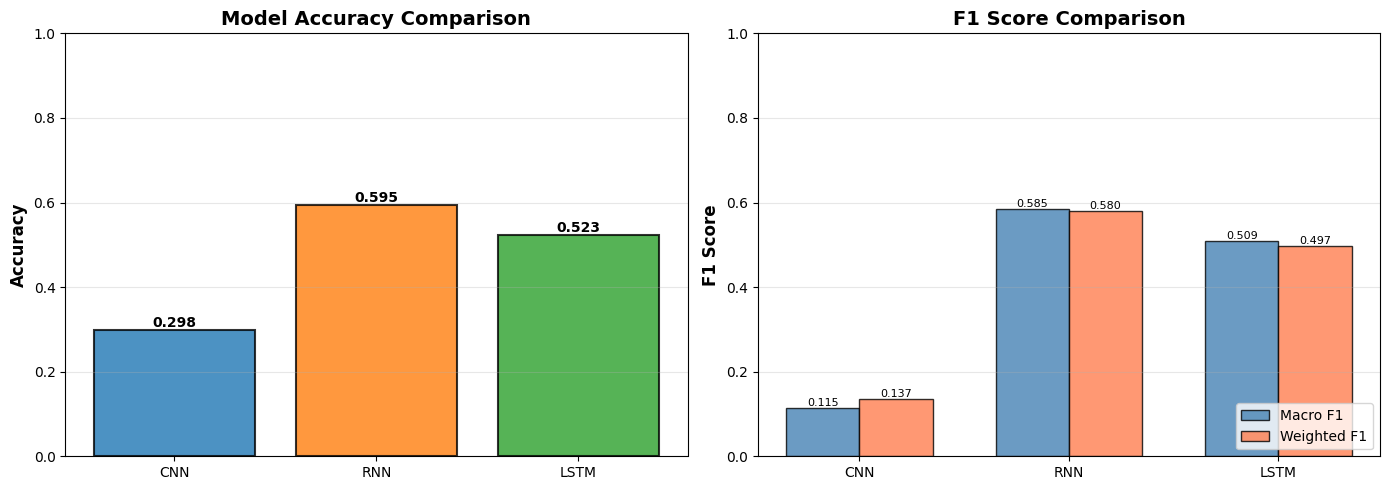

✓ Saved accuracy_f1_comparison.png


In [5]:
# Bar chart: Accuracy and F1 scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
ax1 = axes[0]
bars1 = ax1.bar(results_df['Model'], results_df['Accuracy'], 
                color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'], 
                alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1.0])
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# F1 scores comparison (grouped bars)
ax2 = axes[1]
x = np.arange(len(results_df['Model']))
width = 0.35

bars2 = ax2.bar(x - width/2, results_df['F1_Macro'], width, 
                label='Macro F1', color='steelblue', alpha=0.8, edgecolor='black')
bars3 = ax2.bar(x + width/2, results_df['F1_Weighted'], width, 
                label='Weighted F1', color='coral', alpha=0.8, edgecolor='black')

ax2.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax2.set_title('F1 Score Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(results_df['Model'])
ax2.set_ylim([0, 1.0])
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', fontsize=8)

for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(results_dir / 'accuracy_f1_comparison.png', bbox_inches='tight')
plt.show()
print(f"✓ Saved accuracy_f1_comparison.png")

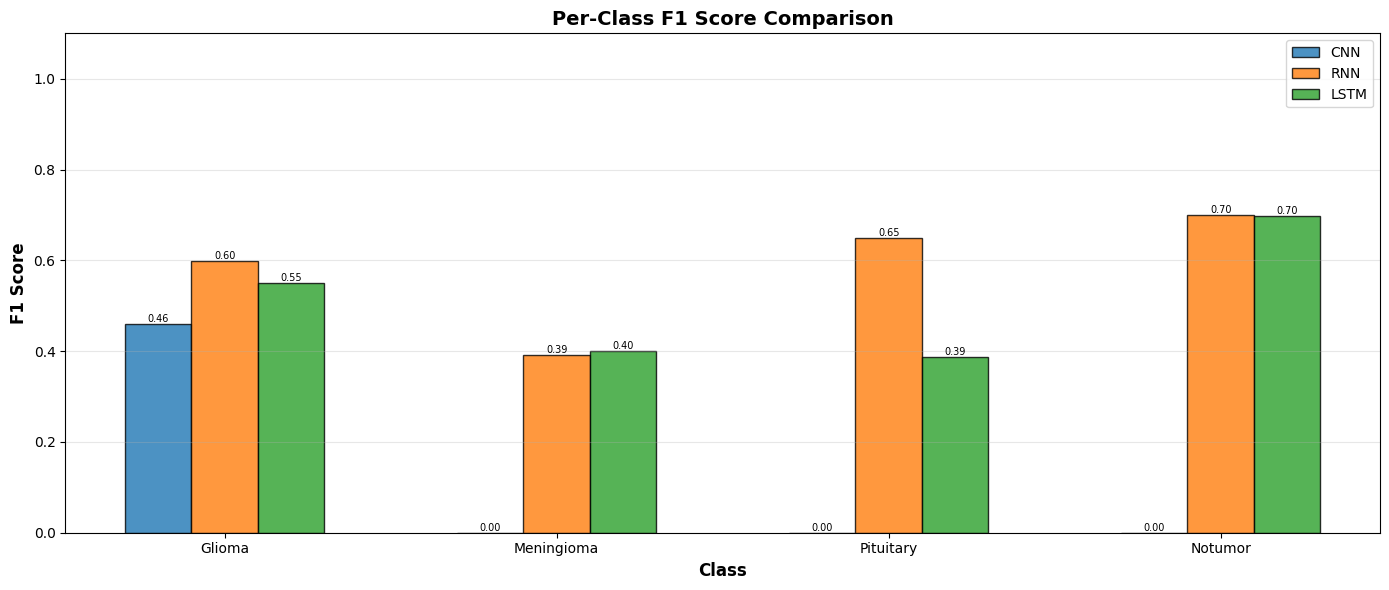

✓ Saved per_class_f1_comparison.png


In [6]:
# Per-class F1 comparison (grouped bar chart)
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(classes))
width = 0.2
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, model_name in enumerate(models):
    model_data = results_df[results_df['Model'] == model_name.upper()].iloc[0]
    f1_scores = [
        model_data['Glioma_F1'],
        model_data['Meningioma_F1'],
        model_data['Pituitary_F1'],
        model_data['NoTumor_F1']
    ]
    
    offset = (i - len(models)/2 + 0.5) * width
    bars = ax.bar(x + offset, f1_scores, width, 
                  label=model_name.upper(), color=colors[i], 
                  alpha=0.8, edgecolor='black', linewidth=1)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=7)

ax.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_title('Per-Class F1 Score Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([c.capitalize() for c in classes])
ax.set_ylim([0, 1.1])
ax.legend(loc='upper right', fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / 'per_class_f1_comparison.png', bbox_inches='tight')
plt.show()
print(f"✓ Saved per_class_f1_comparison.png")

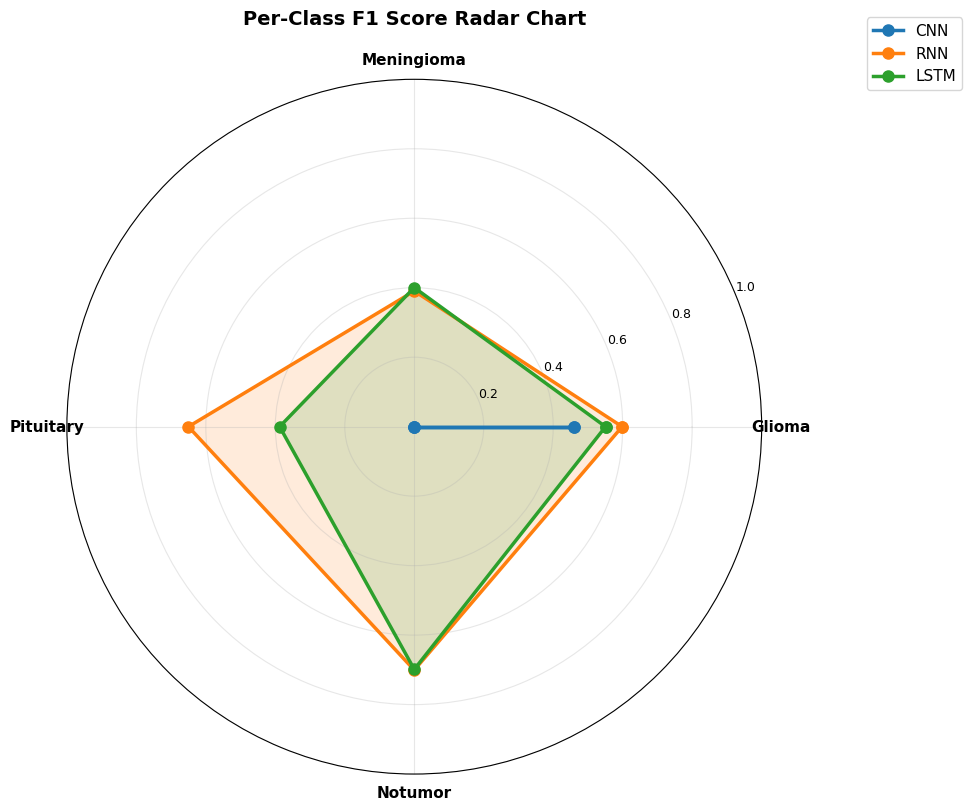

✓ Saved radar_chart_per_class_f1.png


In [7]:
# Radar chart for per-class F1 scores
from math import pi

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Number of variables
categories = [c.capitalize() for c in classes]
N = len(categories)

# Compute angle for each axis
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Complete the circle

# Plot each model
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for i, model_name in enumerate(models):
    model_data = results_df[results_df['Model'] == model_name.upper()].iloc[0]
    values = [
        model_data['Glioma_F1'],
        model_data['Meningioma_F1'],
        model_data['Pituitary_F1'],
        model_data['NoTumor_F1']
    ]
    values += values[:1]  # Complete the circle
    
    ax.plot(angles, values, 'o-', linewidth=2.5, label=model_name.upper(), 
            color=colors[i], markersize=8)
    ax.fill(angles, values, alpha=0.15, color=colors[i])

# Fix axis to go in the right order
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11, fontweight='bold')

# Set y-axis limits
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=9)

# Add legend and title
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
ax.set_title('Per-Class F1 Score Radar Chart', fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / 'radar_chart_per_class_f1.png', bbox_inches='tight')
plt.show()
print(f"✓ Saved radar_chart_per_class_f1.png")

## 4. Side-by-Side Confusion Matrices

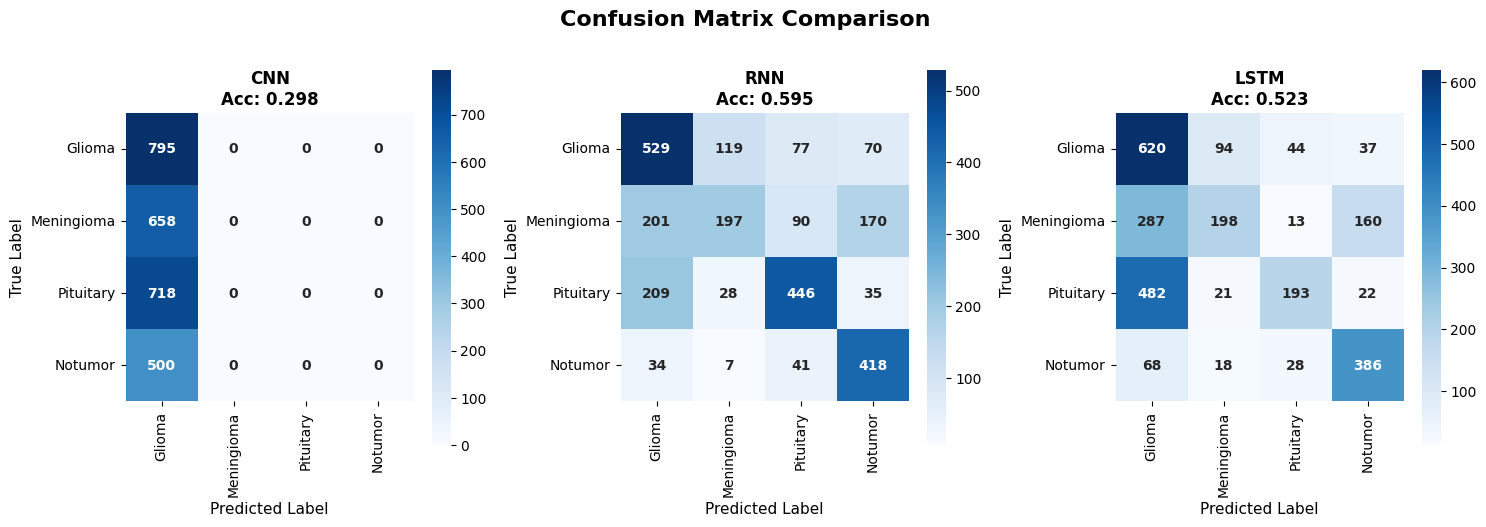

✓ Saved confusion_matrices_comparison.png


In [8]:
# Load and display confusion matrices
fig, axes = plt.subplots(1, len(models), figsize=(5*len(models), 5))
if len(models) == 1:
    axes = [axes]

for idx, model_name in enumerate(models):
    cm_path = artifacts_base / model_name / "cm.npy"
    
    if cm_path.exists():
        cm = np.load(cm_path)
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=[c.capitalize() for c in classes], 
                    yticklabels=[c.capitalize() for c in classes],
                    ax=axes[idx], cbar=True, square=True,
                    annot_kws={'fontsize': 10, 'fontweight': 'bold'})
        
        axes[idx].set_title(f'{model_name.upper()}\nAcc: {results_df[results_df["Model"]==model_name.upper()]["Accuracy"].values[0]:.3f}',
                           fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('True Label', fontsize=11)
        axes[idx].set_xlabel('Predicted Label', fontsize=11)
    else:
        axes[idx].text(0.5, 0.5, f'No CM for {model_name.upper()}',
                      ha='center', va='center', fontsize=12)
        axes[idx].axis('off')

plt.suptitle('Confusion Matrix Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(results_dir / 'confusion_matrices_comparison.png', bbox_inches='tight')
plt.show()
print(f"✓ Saved confusion_matrices_comparison.png")

## 5. Training History Comparison

In [9]:
# Load training history from history.csv
history_data = {}

for model_name in models:
    history_path = artifacts_base / model_name / "history.csv"
    
    if history_path.exists():
        history_data[model_name] = pd.read_csv(history_path)
        print(f"✓ Loaded training history for {model_name.upper()} ({len(history_data[model_name])} epochs)")
    else:
        print(f"⚠ History not found for {model_name.upper()}")

print(f"\n✓ Loaded history for {len(history_data)} models")

✓ Loaded training history for CNN (1 epochs)
✓ Loaded training history for RNN (1 epochs)
✓ Loaded training history for LSTM (1 epochs)

✓ Loaded history for 3 models


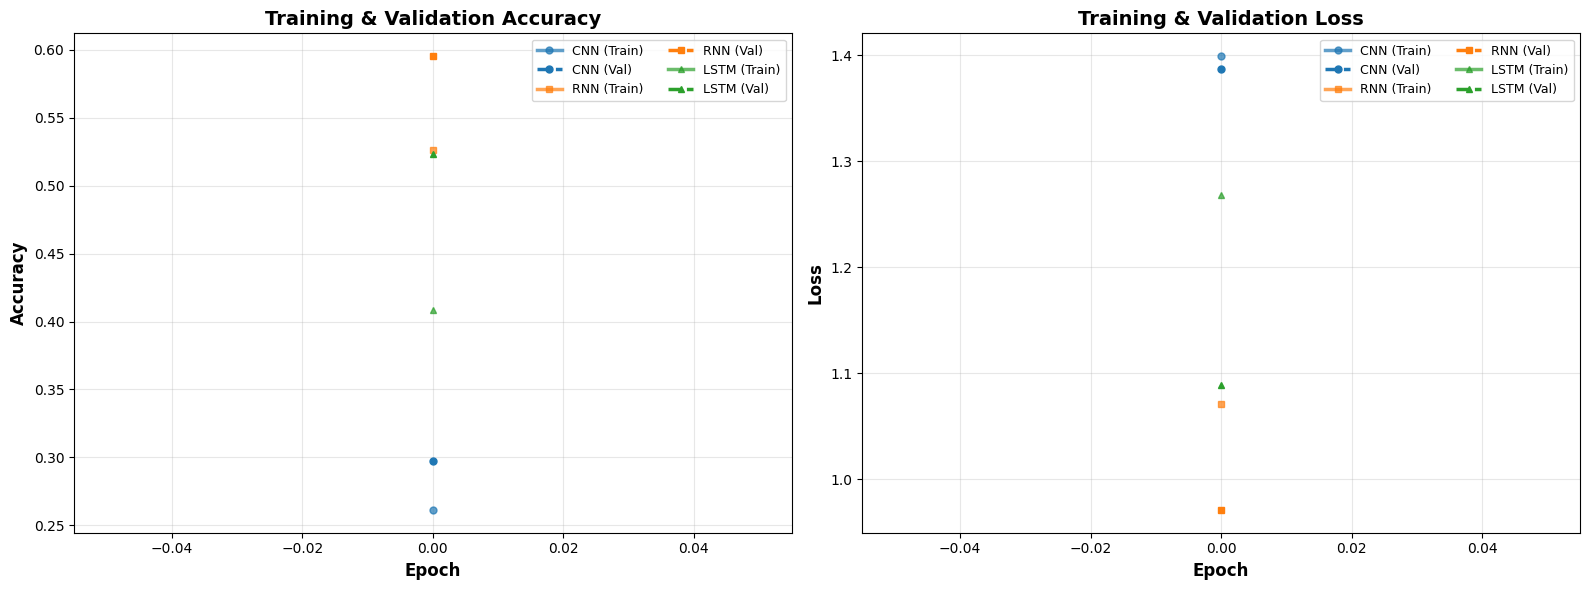

✓ Saved training_curves_comparison.png


In [10]:
# Plot overlaid training curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
markers = ['o', 's', '^', 'D']

# Training accuracy
ax1 = axes[0]
for i, model_name in enumerate(models):
    if model_name in history_data:
        hist = history_data[model_name]
        
        # Check for different column naming conventions
        acc_col = 'accuracy' if 'accuracy' in hist.columns else 'acc'
        val_acc_col = 'val_accuracy' if 'val_accuracy' in hist.columns else 'val_acc'
        
        if acc_col in hist.columns:
            ax1.plot(hist[acc_col], label=f'{model_name.upper()} (Train)', 
                    color=colors[i], linewidth=2.5, marker=markers[i], 
                    markersize=5, markevery=max(1, len(hist)//10), alpha=0.7)
        
        if val_acc_col in hist.columns:
            ax1.plot(hist[val_acc_col], label=f'{model_name.upper()} (Val)', 
                    color=colors[i], linewidth=2.5, linestyle='--', 
                    marker=markers[i], markersize=5, markevery=max(1, len(hist)//10))

ax1.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=9, ncol=2)
ax1.grid(True, alpha=0.3)

# Training loss
ax2 = axes[1]
for i, model_name in enumerate(models):
    if model_name in history_data:
        hist = history_data[model_name]
        
        if 'loss' in hist.columns:
            ax2.plot(hist['loss'], label=f'{model_name.upper()} (Train)', 
                    color=colors[i], linewidth=2.5, marker=markers[i], 
                    markersize=5, markevery=max(1, len(hist)//10), alpha=0.7)
        
        if 'val_loss' in hist.columns:
            ax2.plot(hist['val_loss'], label=f'{model_name.upper()} (Val)', 
                    color=colors[i], linewidth=2.5, linestyle='--', 
                    marker=markers[i], markersize=5, markevery=max(1, len(hist)//10))

ax2.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax2.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax2.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=9, ncol=2)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(results_dir / 'training_curves_comparison.png', bbox_inches='tight')
plt.show()
print(f"✓ Saved training_curves_comparison.png")

## 6. Side-by-Side Predictions on Same Validation Images

In [11]:
# Load sample validation images and predictions from each model
# We'll use example_errors.csv to find interesting cases, or pick random validation images

# First, try to load validation image paths from any model's error examples
sample_images = []
sample_labels = []

for model_name in models:
    errors_path = artifacts_base / model_name / "example_errors.csv"
    if errors_path.exists():
        errors_df = pd.read_csv(errors_path)
        if len(errors_df) > 0 and 'image_path' in errors_df.columns:
            # Take first 12 unique images
            for _, row in errors_df.head(12).iterrows():
                img_path = row['image_path']
                if img_path not in sample_images:
                    sample_images.append(img_path)
                    sample_labels.append(row.get('true_label', 'unknown'))
            break

# If we couldn't find error examples, try to construct from data folder
if len(sample_images) < 12:
    print("⚠ Not enough error examples found, will use alternative method...")
    # Alternative: Load from data directory
    data_dir = Path("../data")
    for cls in classes:
        cls_dir = data_dir / cls
        if cls_dir.exists():
            images = list(cls_dir.glob("*.jpg")) + list(cls_dir.glob("*.png"))
            if images:
                sample_images.append(str(images[0]))
                sample_labels.append(cls)
                if len(sample_images) >= 12:
                    break

sample_images = sample_images[:12]  # Limit to 12
sample_labels = sample_labels[:12]

print(f"✓ Selected {len(sample_images)} validation images for comparison")

✓ Selected 12 validation images for comparison


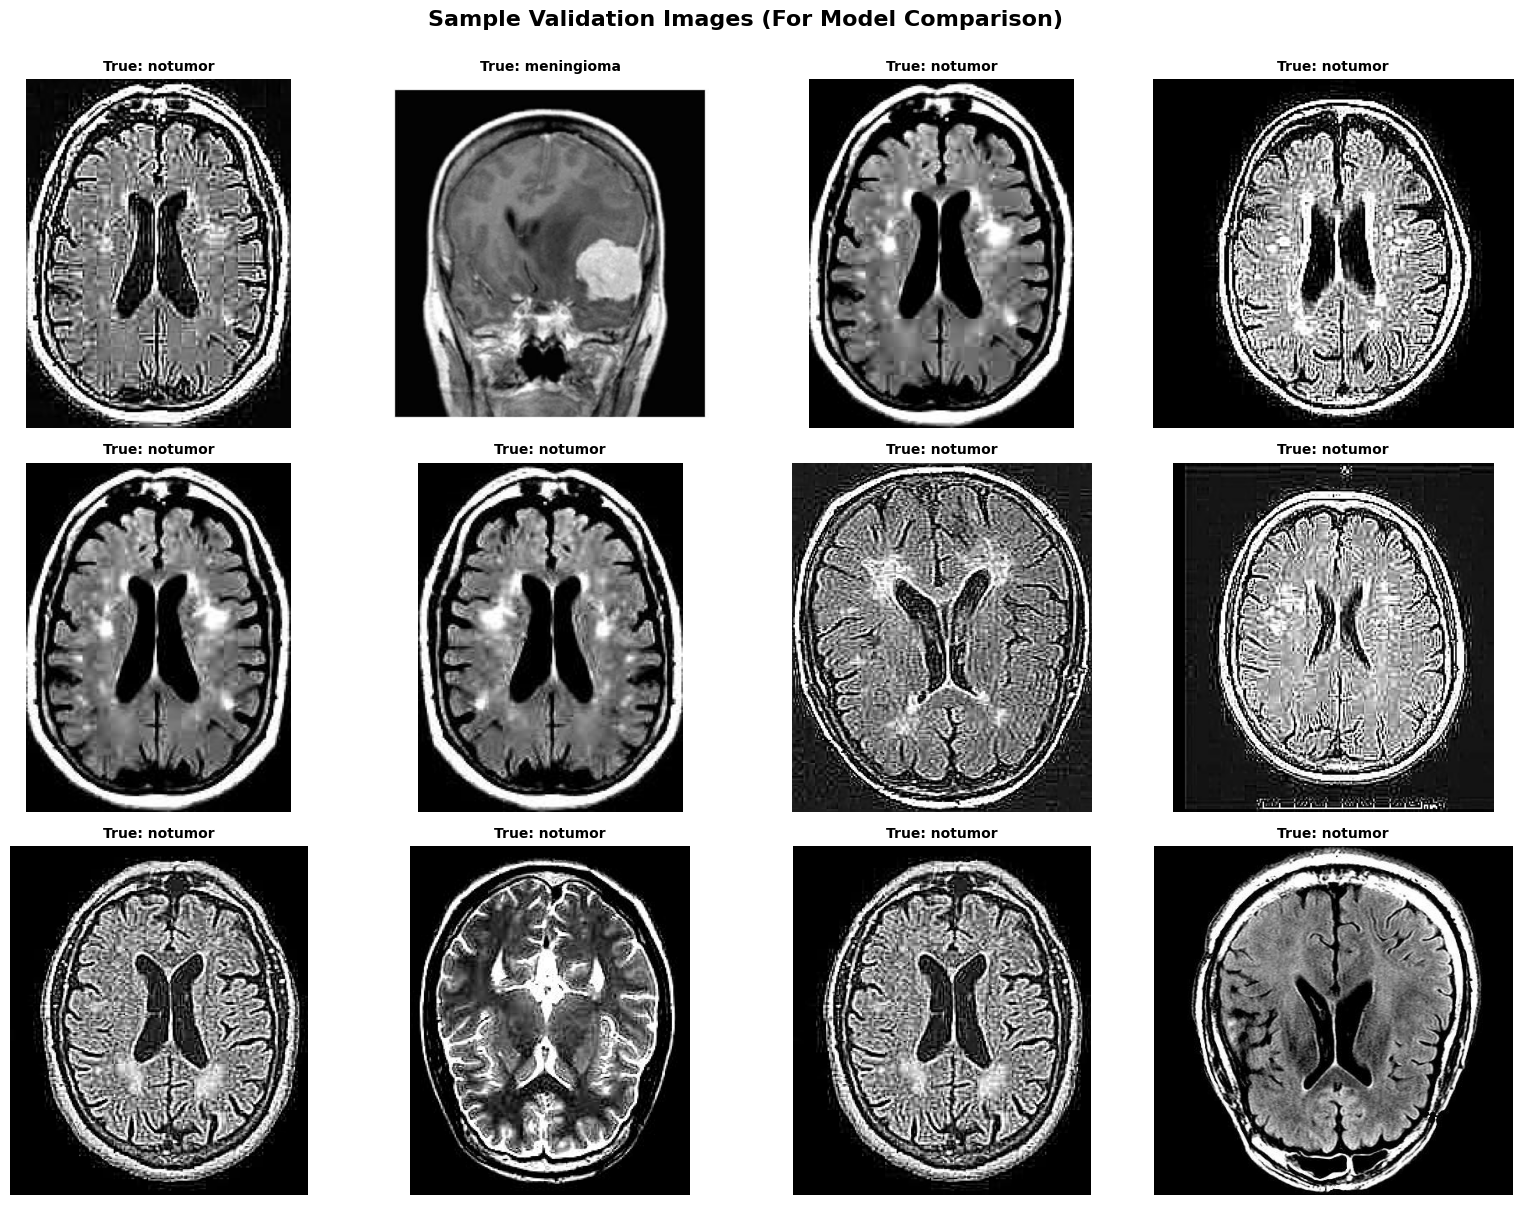

✓ Saved sample_validation_images.png

ℹ Note: To show model predictions, load each trained model and run inference on these images.


In [12]:
# For demonstration: Load predictions if available, otherwise show placeholder
# In a real scenario, you'd need to load models and run inference

# This cell creates a visualization showing the same images with each model's prediction
# Since we can't easily re-run inference here, we'll show the images with their true labels
# and note that full comparison would require model loading

if len(sample_images) > 0:
    n_images = len(sample_images)
    n_cols = 4  # Show 4 images per row
    n_rows = (n_images + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for idx, (img_path, true_label) in enumerate(zip(sample_images, sample_labels)):
        try:
            img = Image.open(img_path).convert('RGB')
            axes[idx].imshow(img)
            axes[idx].set_title(f'True: {true_label}', fontsize=10, fontweight='bold')
            axes[idx].axis('off')
        except Exception as e:
            axes[idx].text(0.5, 0.5, 'Error loading image', 
                          ha='center', va='center', fontsize=10)
            axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(n_images, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Sample Validation Images (For Model Comparison)', 
                fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.savefig(results_dir / 'sample_validation_images.png', bbox_inches='tight')
    plt.show()
    print(f"✓ Saved sample_validation_images.png")
    print("\nℹ Note: To show model predictions, load each trained model and run inference on these images.")
else:
    print("⚠ No validation images available for comparison")

In [13]:
# Create a detailed comparison table for these specific images (if error data available)
# This shows how each model predicted on the same validation images

comparison_data = []

for img_path in sample_images[:12]:
    img_comparison = {'Image': Path(img_path).name}
    
    # Try to find this image in each model's error examples
    for model_name in models:
        errors_path = artifacts_base / model_name / "example_errors.csv"
        if errors_path.exists():
            errors_df = pd.read_csv(errors_path)
            match = errors_df[errors_df['image_path'] == img_path]
            
            if not match.empty:
                pred = match.iloc[0]['predicted_label']
                conf = match.iloc[0].get('predicted_prob', 0.0)
                img_comparison[f'{model_name.upper()}_Pred'] = pred
                img_comparison[f'{model_name.upper()}_Conf'] = f"{conf:.3f}"
            else:
                img_comparison[f'{model_name.upper()}_Pred'] = 'N/A'
                img_comparison[f'{model_name.upper()}_Conf'] = 'N/A'
        else:
            img_comparison[f'{model_name.upper()}_Pred'] = 'N/A'
            img_comparison[f'{model_name.upper()}_Conf'] = 'N/A'
    
    comparison_data.append(img_comparison)

if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    print("\n" + "="*100)
    print("SAMPLE IMAGE PREDICTIONS COMPARISON")
    print("="*100)
    print(comparison_df.to_string(index=False))
    print("="*100)
    
    # Save to CSV
    comparison_df.to_csv(results_dir / 'sample_predictions_comparison.csv', index=False)
    print(f"\n✓ Saved sample_predictions_comparison.csv")
else:
    print("\nℹ No prediction comparison data available (requires error logs from all models)")


SAMPLE IMAGE PREDICTIONS COMPARISON
         Image CNN_Pred CNN_Conf RNN_Pred RNN_Conf LSTM_Pred LSTM_Conf
Tr-no_0781.jpg   glioma    0.257      N/A      N/A       N/A       N/A
Te-me_0014.jpg   glioma    0.257      N/A      N/A       N/A       N/A
Tr-no_0788.jpg   glioma    0.257      N/A      N/A       N/A       N/A
Tr-no_0824.jpg   glioma    0.257      N/A      N/A       N/A       N/A
Tr-no_0574.jpg   glioma    0.257      N/A      N/A       N/A       N/A
Tr-no_0687.jpg   glioma    0.257      N/A      N/A       N/A       N/A
Tr-no_0874.jpg   glioma    0.257      N/A      N/A       N/A       N/A
Tr-no_0780.jpg   glioma    0.257      N/A      N/A       N/A       N/A
Tr-no_1351.jpg   glioma    0.257      N/A      N/A       N/A       N/A
Te-no_0329.jpg   glioma    0.257      N/A      N/A       N/A       N/A
Tr-no_0589.jpg   glioma    0.257      N/A      N/A       N/A       N/A
Te-no_0212.jpg   glioma    0.258      N/A      N/A       N/A       N/A

✓ Saved sample_predictions_comparison.c

## 7. Summary Statistics Table

In [14]:
# Create comprehensive summary statistics
summary_stats = []

for model_name in models:
    metrics = metrics_data[model_name]
    model_row = results_df[results_df['Model'] == model_name.upper()].iloc[0]
    
    # Extract additional metrics
    precision_macro = metrics.get('classification_report', {}).get('macro avg', {}).get('precision', 0.0)
    recall_macro = metrics.get('classification_report', {}).get('macro avg', {}).get('recall', 0.0)
    
    # Training info (if available from history)
    epochs_trained = len(history_data[model_name]) if model_name in history_data else 'N/A'
    final_train_acc = history_data[model_name]['accuracy'].iloc[-1] if model_name in history_data and 'accuracy' in history_data[model_name].columns else 'N/A'
    
    summary_stats.append({
        'Model': model_name.upper(),
        'Architecture': {
            'cnn': 'EfficientNetB0 (Transfer Learning)',
            'rnn': '1D-Conv + BiLSTM',
            'lstm': 'BiLSTM + TimeDistributed + LayerNorm',
            'gnn': 'GCN (SLIC Superpixels)'
        }.get(model_name, 'Unknown'),
        'Test Accuracy': f"{model_row['Accuracy']:.4f}",
        'F1 (Macro)': f"{model_row['F1_Macro']:.4f}",
        'F1 (Weighted)': f"{model_row['F1_Weighted']:.4f}",
        'Precision (Macro)': f"{precision_macro:.4f}",
        'Recall (Macro)': f"{recall_macro:.4f}",
        'Epochs Trained': epochs_trained,
        'Final Train Acc': f"{final_train_acc:.4f}" if isinstance(final_train_acc, float) else final_train_acc
    })

summary_df = pd.DataFrame(summary_stats)

print("\n" + "="*120)
print("COMPREHENSIVE MODEL SUMMARY")
print("="*120)
print(summary_df.to_string(index=False))
print("="*120)

# Save to CSV
summary_df.to_csv(results_dir / 'comprehensive_summary.csv', index=False)
print(f"\n✓ Saved comprehensive_summary.csv")


COMPREHENSIVE MODEL SUMMARY
Model                         Architecture Test Accuracy F1 (Macro) F1 (Weighted) Precision (Macro) Recall (Macro)  Epochs Trained Final Train Acc
  CNN   EfficientNetB0 (Transfer Learning)        0.2976     0.1147        0.1365            0.0744         0.2500               1          0.2613
  RNN                     1D-Conv + BiLSTM        0.5953     0.5850        0.5803            0.5975         0.6055               1          0.5258
 LSTM BiLSTM + TimeDistributed + LayerNorm        0.5230     0.5093        0.4975            0.5890         0.5304               1          0.4083

✓ Saved comprehensive_summary.csv


## 8. Final Summary Report

In [15]:
# Generate markdown report
report_lines = [
    "# Brain Tumor Classification - Model Comparison Report",
    "",
    f"**Generated:** {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}",
    "",
    "## Executive Summary",
    "",
    f"Compared **{len(models)}** models: {', '.join([m.upper() for m in models])}",
    "",
    "### Best Performing Models:",
]

# Rank by accuracy
ranked_by_acc = results_df.sort_values('Accuracy', ascending=False)
report_lines.append(f"- **Accuracy:** {ranked_by_acc.iloc[0]['Model']} ({ranked_by_acc.iloc[0]['Accuracy']:.4f})")

# Rank by F1 macro
ranked_by_f1 = results_df.sort_values('F1_Macro', ascending=False)
report_lines.append(f"- **F1 (Macro):** {ranked_by_f1.iloc[0]['Model']} ({ranked_by_f1.iloc[0]['F1_Macro']:.4f})")

report_lines.extend([
    "",
    "## Performance Comparison",
    "",
    "| Model | Accuracy | F1 (Macro) | F1 (Weighted) |",
    "|-------|----------|------------|---------------|"
])

for _, row in results_df.iterrows():
    report_lines.append(
        f"| {row['Model']} | {row['Accuracy']:.4f} | {row['F1_Macro']:.4f} | {row['F1_Weighted']:.4f} |"
    )

report_lines.extend([
    "",
    "## Per-Class Performance",
    "",
    "| Model | Glioma | Meningioma | Pituitary | No Tumor |",
    "|-------|--------|------------|-----------|----------|"
])

for _, row in results_df.iterrows():
    report_lines.append(
        f"| {row['Model']} | {row['Glioma_F1']:.3f} | {row['Meningioma_F1']:.3f} | "
        f"{row['Pituitary_F1']:.3f} | {row['NoTumor_F1']:.3f} |"
    )

report_lines.extend([
    "",
    "## Generated Visualizations",
    "",
    "1. `accuracy_f1_comparison.png` - Overall performance metrics",
    "2. `per_class_f1_comparison.png` - Per-class F1 scores",
    "3. `radar_chart_per_class_f1.png` - Radar chart comparison",
    "4. `confusion_matrices_comparison.png` - Side-by-side confusion matrices",
    "5. `training_curves_comparison.png` - Training history overlay",
    "6. `sample_validation_images.png` - Sample validation images",
    "",
    "## Files Generated",
    "",
    "- `results_summary.csv` - Main results table",
    "- `comprehensive_summary.csv` - Detailed statistics",
    "- `sample_predictions_comparison.csv` - Per-image predictions",
    "- `results_plots/` - All visualization files",
    "",
    "---",
    "",
    "*End of Report*"
])

report_content = "\n".join(report_lines)

# Save report
with open(results_dir / 'comparison_report.md', 'w') as f:
    f.write(report_content)

print("\n" + "="*80)
print("REPORT GENERATION COMPLETE")
print("="*80)
print(f"✓ Saved comparison_report.md")
print(f"✓ All plots saved to {results_dir}/")
print(f"✓ Summary CSV saved to ../results_summary.csv")
print("="*80)

# Display summary
print("\n📊 QUICK SUMMARY:")
print(f"   Best Accuracy: {ranked_by_acc.iloc[0]['Model']} ({ranked_by_acc.iloc[0]['Accuracy']:.4f})")
print(f"   Best F1 Score: {ranked_by_f1.iloc[0]['Model']} ({ranked_by_f1.iloc[0]['F1_Macro']:.4f})")
print(f"\n   Total visualizations: 6 PNG files")
print(f"   Total reports: 3 CSV files + 1 markdown report")


REPORT GENERATION COMPLETE
✓ Saved comparison_report.md
✓ All plots saved to ..\results_plots/
✓ Summary CSV saved to ../results_summary.csv

📊 QUICK SUMMARY:
   Best Accuracy: RNN (0.5953)
   Best F1 Score: RNN (0.5850)

   Total visualizations: 6 PNG files
   Total reports: 3 CSV files + 1 markdown report


In [16]:
# Display the markdown report
from IPython.display import Markdown

Markdown(report_content)

# Brain Tumor Classification - Model Comparison Report

**Generated:** 2025-10-12 19:55:17

## Executive Summary

Compared **3** models: CNN, RNN, LSTM

### Best Performing Models:
- **Accuracy:** RNN (0.5953)
- **F1 (Macro):** RNN (0.5850)

## Performance Comparison

| Model | Accuracy | F1 (Macro) | F1 (Weighted) |
|-------|----------|------------|---------------|
| CNN | 0.2976 | 0.1147 | 0.1365 |
| RNN | 0.5953 | 0.5850 | 0.5803 |
| LSTM | 0.5230 | 0.5093 | 0.4975 |

## Per-Class Performance

| Model | Glioma | Meningioma | Pituitary | No Tumor |
|-------|--------|------------|-----------|----------|
| CNN | 0.459 | 0.000 | 0.000 | 0.000 |
| RNN | 0.598 | 0.390 | 0.650 | 0.701 |
| LSTM | 0.551 | 0.400 | 0.388 | 0.699 |

## Generated Visualizations

1. `accuracy_f1_comparison.png` - Overall performance metrics
2. `per_class_f1_comparison.png` - Per-class F1 scores
3. `radar_chart_per_class_f1.png` - Radar chart comparison
4. `confusion_matrices_comparison.png` - Side-by-side confusion matrices
5. `training_curves_comparison.png` - Training history overlay
6. `sample_validation_images.png` - Sample validation images

## Files Generated

- `results_summary.csv` - Main results table
- `comprehensive_summary.csv` - Detailed statistics
- `sample_predictions_comparison.csv` - Per-image predictions
- `results_plots/` - All visualization files

---

*End of Report*